In [7]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, transpile, execute
from qiskit.circuit.library import QFT

In [12]:
eval_qubit = 4
total_qubit = eval_qubit+1

p = 0.34
theta_p = 2 * np.arcsin(np.sqrt(p))
theta_for_q = 2 * theta_p 

shots = 10000

In [13]:
qreg_q = QuantumRegister(total_qubit, 'q')
creg_c = ClassicalRegister(total_qubit, 'c')
circuit = QuantumCircuit(qreg_q, creg_c)

In [14]:
circuit.h(qreg_q[0:eval_qubit])
circuit.ry(theta_p, qreg_q[eval_qubit])
circuit.barrier()

for i in range(eval_qubit):
    circuit.cry(theta_for_q * (2**i), qreg_q[i], qreg_q[eval_qubit])
    circuit.barrier()
    
circuit.append(QFT(eval_qubit, inverse=True, do_swaps=True), 
               qreg_q[0:eval_qubit])
circuit.barrier()

for i in range(4):
    circuit.measure(qreg_q[i], creg_c[i])

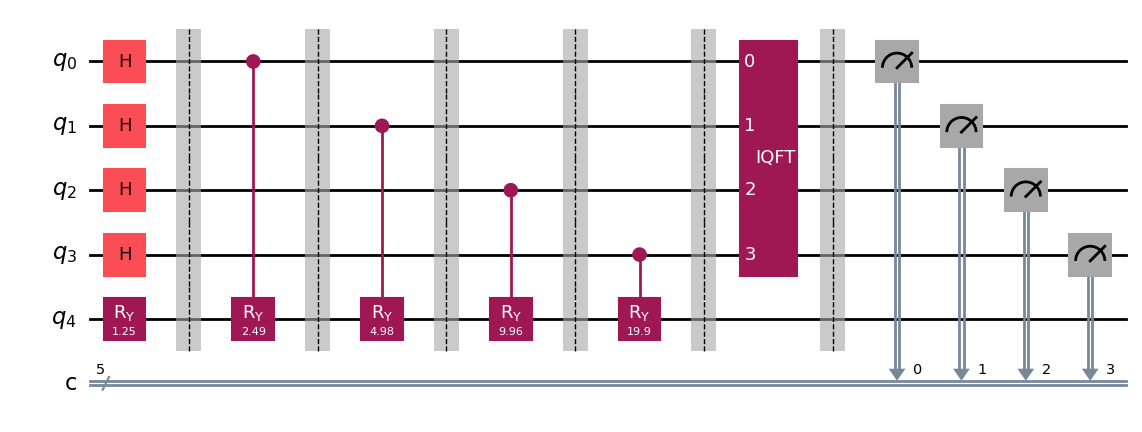

In [15]:
circuit.draw(output='mpl', style="iqp")

In [16]:
simulator = Aer.get_backend('qasm_simulator')
circuit = transpile(circuit, simulator)
result = execute(circuit, simulator, shots=shots).result()
counts = result.get_counts(circuit)

In [17]:
counts #반대 순서, 앞에 전부 0

{'01010': 19,
 '00111': 21,
 '00110': 16,
 '01000': 14,
 '01001': 17,
 '00101': 40,
 '01011': 44,
 '00100': 219,
 '01100': 207,
 '01110': 101,
 '00011': 4627,
 '00001': 29,
 '00000': 22,
 '00010': 97,
 '01111': 15,
 '01101': 4512}

Post Processing

In [26]:
counts = {key: value / shots for key, value in counts.items()}

In [27]:
p_tilde = [np.round(np.sin(i*np.pi/(2**eval_qubit))**2,3) for i in range(2**(eval_qubit-1)+1)]

In [28]:
p_tilde

[0.0, 0.038, 0.146, 0.309, 0.5, 0.691, 0.854, 0.962, 1.0]

In [29]:
probs = np.zeros(2**eval_qubit, dtype=float)
for state, value in counts.items():
    state_decimal = int(state, 2)
    probs[state_decimal] = value
    
freqs =[]
freqs.append(probs[0])
i = 1
while i < 2**eval_qubit/2:
    # print(f'These states correspond to the same bin: {i} and {2**m-i}')
    freqs.append(probs[i] + probs[2**eval_qubit-i])
    i += 1
freqs.append(probs[2**(eval_qubit-1)])

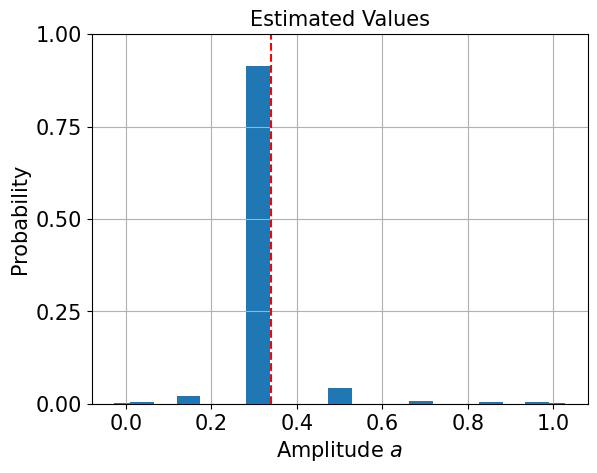

In [30]:
gridpoints = list(p_tilde)
probabilities = list(freqs)

plt.bar(gridpoints, probabilities, width=0.5 / len(probabilities))
plt.axvline(p, color="r", ls="--")
plt.xticks(size=15)
plt.yticks([0, 0.25, 0.5, 0.75, 1], size=15)
plt.title("Estimated Values", size=15)
plt.ylabel("Probability", size=15)
plt.xlabel(r"Amplitude $a$", size=15)
plt.ylim((0, 1))
plt.grid()
plt.show()